<font size="+1">A Bayesian Approach to Final Adjusted Values</font> <br><br>

In this workbook we are going to estimate final adjusted values (FAVs) for a list of compounds using a couple of different methods. FAVs are physical-chemical property values adjusted for thermodynamic consistency, as each of the properties can be expressed as a combination of the other properties (Cole and Mackay, 2000; Beyer et al., 2002). The properties of interest are as follows:
<font size="+1">Solubilities</font> <br><br>
Subcooled liquid vapour pressure (PL/Pa) - converted to subcooled liquid air solubility (SAL/mol m-3) as SAL = PL/RT (Cole & Mackay, 2000)
Subcooled liquid water solubilty (SWL/mol m-3)
Subcooled liquid octanol solubility (SOL/mol m-3)
<font size="+1">Dimensionless Partition Coefficients</font> <br><br>
Octanol/Water partition coefficient (KOW)
Octanol/Air partition coefficient (KOA)
Air/Water partition coefficent (KAW) - can be derived from Henry's law constant (H/Pa m3 mol-1) as KAW = H/RT

The properties are related as:<br>
logKaw = logSa - logSw (1)<br>
Log Koa = LogSo - logSa (2)<br>
LogKow = logSow - logSwo (3) (note that this is dry octanol Kow)<br>
LogSo/Sw = logSo-logSw (4)<br>
From this, we can derive a set of equation which gives the "misclosure error" (w) between the data points, where w is 0 in a completely consistent data set, such as our FAVs, as (Schenker et al., 2005):<br>
logKaw - logKow + logKoa = w0 (5)<br>
then we can adjust these values with an adjustment, vi, where (if the relative uncertainty between the values is equal) 
w0 = v1-v2+v3 (6) (for the equation above) such that:<br>
FAVKaw = logKaw-v1 (7)<br>
FAVKow = logKow-v2 (8)<br>
FAVKoa = logKoa-v3 (9)<br>
This system can be extended so that instead of a single equation (5) we have a system of equations, based on (1)-(4) as:<br>
log(Sa) - log(Sw) -log(Kaw) = w1 (10)<br>
log(Sa) - log(So) + log(Koa) = w2 (11)<br>
log(Sw) - log(So) + log(Kow) = w3(12) (note that this is dry octanol Kow)<br>

The temperature dependence of these properties(K or S) can be estimated over a small temperature gradient using a modified Van't Hoff equation as ln(K/S(T2)) = ln(K/S(T1))- dU/R(1/T2-1/T1), where dU is the internal energy of phase change. All values entered into the model should be at 25°C. This paper has used properties corrected from within 5°C of that value (20 - 30 °C, inclusive) to derive the LDVs, unless otherwise noted. 

These internal energy values can also be adjusted, using a similar set of equations to the above (Beyer et al., 2002):<br>
dUaw - dUow +dUoa = w4 (13a) or equivalently dUa - dUw -dUow +dUoa = w4 (13b).<br>


1. Iterative: Adjusted using the iterative approach of Beyer et al. (2002) DOI: 10.1002/etc.5620210508. 
2. Least-Squares: Adjusted using the approach of Schenker et al.(2005) DOI: 10.1021/es0502526
3. Bayesian approach: Estimate the probability distribution of each property value using Bayes' theorem, which is the subject of this paper.
***Question - Can I combine the least-squares approach with a Bayesian approach? Is it just that I would need to change my maximum likelihood estimator?***

When we consider the problem of having a diverse set of inconsistent measured values for the same properties, we can see that  it essentially breaks down into two parts:
1. A prior belief as to what the value of a measured property should be, based on its relationship to the other measured values and
2. An observation or set of observations of the property.

This is a classic example of Bayes' theorem (see e.g. wikipedia), and so this problem is amenable to a simple Bayesian approach. The Bayesian approach also has the advantage of taking an "uncertainty first" view of data and of generating a probability distribution for every measured value. Uncertainty in physico-chemical properties is often one of the most important sources of uncertainty in a chemical fate model, but this uncertainty can be difficult to quantify as measured and modelled values can diverge significantly, but the reported uncertainty for each is typically very small, and it can be hard to tell how well we know what we think we know. The Bayesian approach is ready-made for robust uncertainty analysis, as the probability distributions required for a Monte Carlo analysis are the outputs of a Bayesian model.

This notebook will walk through this approach, providing an open-source tool for anyone familiar with basic Python.

In [1]:
#First, lets load our data.
import pandas as pd
import numpy as np
import math
LDV = pd.read_excel('LDV_Data.xlsx', index_col = 2)#literature derived values (LDVs) for each compound with a normal standard deviation.
#LDV.loc[:,'LogSa'] = np.log10(10**(LDV.LogPL)/(R*T))#Convert to mol/m³
#LDV.loc[LDV.LogPL==0,'LogSa'] = 0
#LDV.loc[:,'LogSa SD'] = np.log10(10**(LDV.loc[:,'LogPL SD'])/(R*T)) #Convert standard deviation to mol/m³
#LDV.loc[LDV.LogPL==0,'LogSa'] = 0
LDV.info()

<class 'pandas.core.frame.DataFrame'>
Index: 64 entries, cyclopentadecanone to Octinoxate
Data columns (total 31 columns):
Class             64 non-null object
Order             64 non-null int64
CAS No.           64 non-null object
∆VAPH/kJ·mol-1    64 non-null float64
∆VAPH SD          64 non-null float64
∆WH/kJ·mol-1      64 non-null int64
∆WH SD            64 non-null int64
∆OH/kJ·mol-1      64 non-null int64
∆OH SD            64 non-null int64
∆OAU/kJ·mol-1     64 non-null float64
∆OAU SD           64 non-null float64
∆AW/kJ·mol-1      64 non-null float64
∆AWU SD           64 non-null float64
∆OW/kJ·mol-1      64 non-null float64
∆OWU SD           64 non-null float64
LogKOA            64 non-null float64
LogKOA SD         64 non-null float64
LogKOW            64 non-null float64
LogKOW SD         64 non-null float64
LogKAW            64 non-null float64
LogKAW SD         64 non-null float64
LogPL             64 non-null float64
LogPL SD          64 non-null float64
LogSWL         

In [2]:
#First, we will combine the LDV and the associated uncertainty into a single variable with a mean and a standard deviation
#To perform the inital uncertainty propagation we will use standard uncertainty propagation in a package "uncertainties"
#(source: https://uncertainties-python-package.readthedocs.io/en/latest/)
import uncertainties
from uncertainties import ufloat
from uncertainties import unumpy
import pdb
#Now, we are going to make each of our LDVs into uncertain variables with the uncertaintites through this package.
#We will make a separate dataframe for the uncertain values
startcol = 3 #First column with LDVs in it. Column order should have all data identifiers first, followed by LDVs
#and their standard deviations in pairs
uLDV = pd.DataFrame(index = LDV.index)
colnames =['dVAPH','dWH','dOH','dOAU','dAWU','dOWU','LogKOA','LogKOW','LogKAW','LogPL','LogSW','LogSO','dfusS','Tm']
i = 0
#pdb.set_trace()
for idx,cols in enumerate(LDV.columns[startcol:]):
    #pdb.set_trace()
    if idx/2 != math.ceil(idx/2): #Skip every other column, which have the standard deviations.
        pass
    else:
        #print(idx)
        colname = colnames[i]
        uLDV.loc[:,colname] = unumpy.uarray(LDV.loc[:,cols],LDV.iloc[:,idx+startcol+1])#adding 5 to get to first SD value
        i+=1
#Then, lets convert our vapour pressure to a solubility as Sa = VP/RT
R = 8.314 #J/molK
T = 298.15 #K
uLDV.loc[:,'LogSA'] = unumpy.log10(10**(uLDV.LogPL)/(R*T))#Convert to mol/m³
uLDV.loc[uLDV.LogPL==0,'LogSA'] = np.nan #Convert zeros to nan\
#Here we will also convert the wet octanol partition coefficient to dry so that we are all on the same page
uLDV.loc[:,'LogKOWd'] = 1.35*uLDV.LogKOW - 1.58
uLDV.loc[uLDV.LogKOW==0,'LogKOWd'] = np.nan #Convert zeros to nan\
uLDV = uLDV.replace(0,np.nan) #Convert all zeros to nans for the next part
#NumProps = 
uLDV

,dVAPH,dWH,dOH,dOAU,dAWU,dOWU,LogKOA,LogKOW,LogKAW,LogPL,LogSW,LogSO,dfusS,Tm,LogSA,LogKOWd
Compound Name,,,,,,,,,,,,,,,,
cyclopentadecanone,58+/-15,NaN,NaN,36+/-7,NaN,NaN,6.6+/-1.3,6.0+/-1.2,NaN,-0.3+/-0.4,-2.33+/-0.23,NaN,27.4+/-2.0,63.8+/-3.0,-3.7+/-0.4,6.5+/-1.6
15-pentadecanolide,77.2+/-2.6,NaN,NaN,NaN,NaN,NaN,NaN,6.1+/-0.6,NaN,-1.04+/-0.10,-2.88+/-0.29,NaN,22.6+/-2.3,34.3+/-1.6,-4.44+/-0.10,6.6+/-0.8
Musk Ambrette,80+/-16,NaN,NaN,69.0+/-2.8,NaN,NaN,8.03+/-0.11,NaN,NaN,-1.23+/-0.19,NaN,NaN,NaN,85.2+/-0.5,-4.62+/-0.19,NaN
16-hexadecanolide,73+/-10,NaN,NaN,52+/-10,NaN,NaN,7.3+/-1.5,7.3+/-1.5,NaN,-1.1+/-0.4,-3.28+/-0.33,NaN,24.9+/-2.5,35.5+/-0.7,-4.5+/-0.4,8.3+/-2.0
Celestolide,NaN,NaN,NaN,65+/-13,NaN,NaN,7.6+/-1.5,5.7+/-1.1,NaN,-0.77+/-0.08,-1.34+/-0.13,NaN,NaN,78.0+/-0.5,-4.16+/-0.08,6.1+/-1.5
Muskonate,78+/-16,NaN,NaN,65+/-13,NaN,NaN,7.8+/-1.6,3.6+/-0.7,NaN,-1.34+/-0.29,-0.51+/-0.05,NaN,NaN,17.4+/-0.9,-4.74+/-0.29,3.2+/-1.0
Phantolide,70+/-14,NaN,NaN,62+/-6,NaN,NaN,7.60+/-0.23,5.8+/-1.2,NaN,-0.78+/-0.24,-1.33+/-0.13,NaN,NaN,59.8+/-2.4,-4.17+/-0.24,6.2+/-1.6
Cervolide,62+/-19,NaN,NaN,48+/-10,NaN,NaN,7.7+/-1.5,4.4+/-0.9,NaN,-1.05+/-0.27,-0.87+/-0.09,NaN,NaN,-27.1+/-2.7,-4.44+/-0.27,4.3+/-1.2
Traseolide,77+/-15,NaN,NaN,64+/-13,NaN,NaN,7.95+/-0.33,5.7+/-1.1,NaN,-1.42+/-0.33,-2.66+/-0.27,NaN,NaN,-50+/-15,-4.82+/-0.33,6.1+/-1.5


In [3]:
#This section is somewhat misguided & ended up being unneccessary - but still provides a check possibly
#Now we can set up the initial guesses as to the value of each property, based on the values of the others.
#This uses Equations 1 - 5 (excluding 4 for wet octanol), but instead of calculating the misclosure error we will
#just calculate the projected value of each property. For each property, there are thus 4 equations that describe it,
#which we get by just substituting the different values into the four equations above.
dfp = pd.DataFrame(index = uLDV.index)
dfp.loc[:,'LogKAW1'] = uLDV.LogSA - uLDV.LogSW 
dfp.loc[:,'LogKOW1'] = uLDV.LogSO - uLDV.LogSW
dfp.loc[:,'LogKOA1'] = uLDV.LogSO - uLDV.LogSA
dfp.loc[:,'LogKAW2'] = uLDV.LogKOWd - uLDV.LogKOA
dfp.loc[:,'LogKOW2'] = uLDV.LogKAW + uLDV.LogKOA
dfp.loc[:,'LogKOA2'] = uLDV.LogKOWd - uLDV.LogKAW
dfp.loc[:,'LogKAW3'] = dfp.LogKOW1 - uLDV.LogKOA
dfp.loc[:,'LogKOW3'] = dfp.LogKAW1 + uLDV.LogKOA
dfp.loc[:,'LogKOA3'] = dfp.LogKOW1 - uLDV.LogKAW
dfp.loc[:,'LogKAW4'] = uLDV.LogKOWd - dfp.LogKOA1
dfp.loc[:,'LogKOW4'] = uLDV.LogKAW + dfp.LogKOA1
dfp.loc[:,'LogKOA4'] = uLDV.LogKOWd - dfp.LogKAW1
dfp[unumpy.isnan(dfp)] = np.nan
#Because we don't have a

In [8]:
#Lets try something - lets pretend that the data are the coefficients and the coefficients are the data ie for
#one set of properties, we have an equation like

X1 = [-1,1,1] #Kow,Kaw,Koa
y = 0

In [80]:
#So here we can try a simple case of just 3 parameters Kow, Kaw, Koa and see what we get. To get this solution, we will use 
#the data as the coefficients in a regression of 0 = LogKOW*(-1) + LogKAW*(1)+LogKOA*(1) where our "observations" in
#this case are:
x = [-1,1,1] #Kow,Kaw,Koa
y = 0
#Then, we set up our Bayesian model with the measurements as priors for the model regression parameters. This use of a strong 
#prior reflects our knowledge of the measured values of the compounds, while the model tells us whether this works.
#For this example we are using p,p'-DDE as our test compound. 
import pymc3 as pm
import arviz as az
comp = "p,p'- DDE"
basic_model = pm.Model()
beta = [0,0,0]
with basic_model:
    #Define priors
    sigma = pm.HalfCauchy('sigma', beta=1, testval=1.) #Model error
    #alpha = pm.Normal('alpha', 0, sigma=1e-3) #Acceptable misclosure error
    #For the phys-chem properties, we have some choices of priors depending on our confidence in the data.
    #For our defaults we can use normal distributions, since we have measured values and have adjusted them to account
    #for our level of confidence. Of course, th
    beta[0] = pm.Normal('LogKOWd', mu = uLDV.loc[comp,'LogKOWd'].n, sigma=uLDV.loc[comp,'LogKOWd'].s) #.n = nominal value and .s = std dev.
    beta[1] = pm.Normal('LogKAW', mu = uLDV.loc[comp,'LogKAW'].n, sigma=uLDV.loc[comp,'LogKAW'].s)
    beta[2] = pm.Normal('LogKOA', mu = uLDV.loc[comp,'LogKOA'].n, sigma=uLDV.loc[comp,'LogKOA'].s)
    #Students T distribution has fatter tails, so implies less confidence in the values. We can use this as a way of saying
    #that we think there might be some bias in the measured values.
    #beta[0] = pm.StudentT('LogKOW', nu = 1,mu = uLDV.loc[comp,'LogKOW'].n, sd=uLDV.loc[comp,'LogKOW'].s) #.n = nominal value and .s = std dev.
    #beta[1] = pm.StudentT('LogKAW', nu = 1,mu = uLDV.loc[comp,'LogKAW'].n, sd=uLDV.loc[comp,'LogKAW'].s)
    #beta[2] = pm.StudentT('LogKOA', nu = 1,mu = uLDV.loc[comp,'LogKOA'].n, sd=uLDV.loc[comp,'LogKOA'].s)
    #beta[3] = 
    
    mu = beta[0]*x[0] + beta[1]*x[1] + beta[2]*x[2]
    
    # Likelihood (sampling distribution) of observations
    #Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=y)#Normal
    Y_obs = pm.StudentT('Y_obs',nu = 3, mu=mu, sigma=sigma, observed=y)#For robust regression (broader tails)
    


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [LogKOA, LogKAW, LogKOW, sigma]
Sampling 4 chains: 100%|██████████████████████████████████████████████████| 260000/260000 [02:09<00:00, 2002.91draws/s]


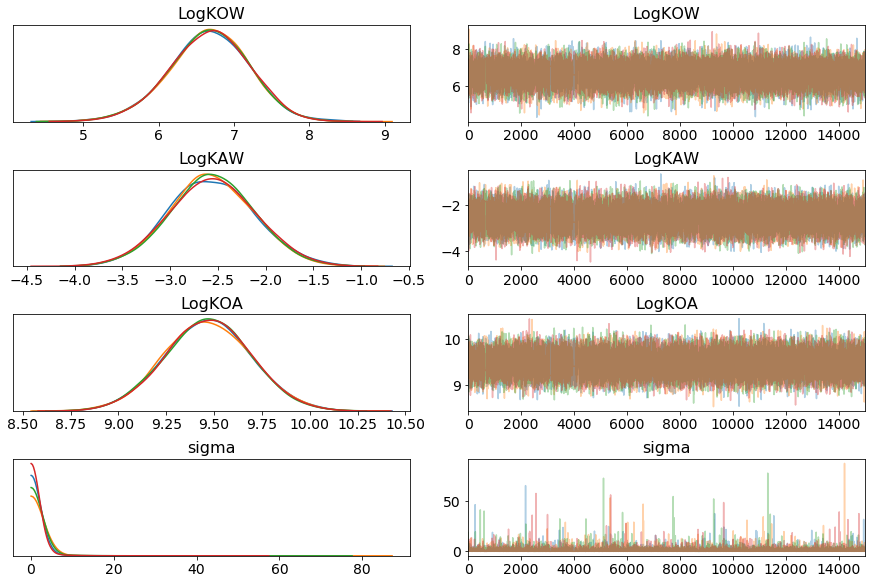

In [81]:
with basic_model:
    # instantiate sampler - without this we just use NUTS
    #step = pm.Slice()
    # draw 5000 posterior samples
    trace = pm.sample(15000, tune=50000)#, step=step)
pm.traceplot(trace);

In [82]:
pm.summary(trace) #Students T distribution on model, normal on priors except for Koa which we think might be incorrect
#You can see that this model performed fairly well - things converged nicely.
##OLD##
#You can see that the above situation something weird was happening - we have 3 divergences and the model is not converging
#extremeley well. From the below plot you can see that the mean values of Kow and Kaw were not adjusted much but Koa was,
#which might indicate that our measurement result for Koa is off. Looking at our data, we can see that for Koa we only 
#have a single, indirect measurement by GC-RT.

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
LogKOW,6.669165,0.524402,0.004143,5.625343,7.687981,18287.203699,0.999997
LogKAW,-2.557592,0.443991,0.003094,-3.440482,-1.694310,20175.713546,1.000034
LogKOA,9.468851,0.221621,0.001575,9.036103,9.905819,22758.214084,1.000025
sigma,1.020708,1.857707,0.010749,0.019453,3.128570,29311.519092,1.000069


In [4]:
#Now, let's try to extend this to a case where we know all six of the basic phys-chem properties. This represents
#the situation where we have three equations with six unkowns (as per Schenker 2005):
#LogSA*(1)+ LogSw *(-1) + LogKAW *(-1)= 0 [1 -1 0 -1 0 0] = 0
#LogSA*(1)+ LogSo *(-1) + LogKOA *(1)= 0 [1 0 -1 0 0 1] = 0
#LogSw*(1)+ LogSo *(-1) + LogKOA *(1)= 0 [0 1 -1 0 1 0] = 0
#this case are:Kaw,
basemat = np.array([[1,-1,0,-1,0,0],[1,0,-1,0,0,1],[0,1,-1,0,1,0]])  #Order is: Sa, Sw, So, Kaw, Kow, Koa
X = basemat
y = 0
#Then, we set up our Bayesian model with the measurements as priors for the model regression parameters. This use of a strong 
#prior reflects our knowledge of the measured values of the compounds, while the model tells us whether this works.
#For this example we are using Tonalide as our test compound. 
import pymc3 as pm
import arviz as az
comp = "p,p'- DDE"
props_model = pm.Model()
beta = [0,0,0,0,0,0]
with props_model:
    #Define priors
    sigma = pm.HalfCauchy('sigma', beta=1., testval=1.) #Model error
    #alpha = pm.Normal('alpha', 0, sigma=1e-3) #Acceptable misclosure error
    #For the phys-chem properties, we have some choices of priors depending on our confidence in the data.
    #For our defaults we can use normal distributions, since we have measured values and have adjusted them to account
    #for our level of confidence. Of course, th
    beta[0] = pm.Normal('LogSA', mu = uLDV.loc[comp,'LogSA'].n, sigma=uLDV.loc[comp,'LogSA'].s) #.n = nominal value and .s = std dev.
    beta[1] = pm.Normal('LogSW', mu = uLDV.loc[comp,'LogSW'].n, sigma=uLDV.loc[comp,'LogSW'].s)
    beta[2] = pm.Normal('LogSO', mu = uLDV.loc[comp,'LogSO'].n, sigma=uLDV.loc[comp,'LogSO'].s)
    beta[3] = pm.Normal('LogKAW', mu = uLDV.loc[comp,'LogKAW'].n, sigma=uLDV.loc[comp,'LogKAW'].s) #.n = nominal value and .s = std dev.
    #Kow can be converted to 
    #beta[4] = pm.Normal('LogKOWd', mu = uLDV.loc[comp,'LogKOWd'].n, sigma=uLDV.loc[comp,'LogKOWd'].s) 
    beta[4] = pm.Normal('LogKOW', mu = uLDV.loc[comp,'LogKOW'].n, sigma=uLDV.loc[comp,'LogKOW'].s)
    beta[5] = pm.Normal('LogKOA', mu = uLDV.loc[comp,'LogKOA'].n, sigma=uLDV.loc[comp,'LogKOA'].s)
    #Students T distribution has fatter tails, so implies less confidence in the values. We can use this as a way of saying
    #that we think there might be some bias in the measured values.
    #beta[3] = pm.StudentT('LogKOW', nu = 1,mu = uLDV.loc[comp,'LogKOW'].n, sd=uLDV.loc[comp,'LogKOW'].s) #.n = nominal value and .s = std dev.
    #beta[4] = pm.StudentT('LogKAW', nu = 1,mu = uLDV.loc[comp,'LogKAW'].n, sd=uLDV.loc[comp,'LogKAW'].s)
    #beta[5] = pm.StudentT('LogKOA', nu = 1,mu = uLDV.loc[comp,'LogKOA'].n, sd=uLDV.loc[comp,'LogKOA'].s)
    #beta[3] = 
    
    epsilon = np.dot(X,beta) #This gives us the misclosure error for each of the three equations
    #The model tries to fit to an observation, in this case that the misclosure should be 0.
    mu = np.sum(epsilon**2)#Here we are going to use the sum of squares, equivalent to the Schenker method, but Bayesian
    
    # Likelihood (sampling distribution) of observations
    #Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=y)#Normal
    Y_obs = pm.StudentT('Y_obs',nu = 3, mu=mu, sigma=sigma, observed=y)#Students for robust regression (broader tails)
    sixparam_trace = pm.sample(15000, tune=50000)#, step=step)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [LogKOA, LogKOW, LogKAW, LogSO, LogSW, LogSA, sigma]
Sampling 4 chains: 100%|██████████████████████████████████████████████████| 260000/260000 [01:56<00:00, 2222.64draws/s]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [LogKOA, LogKOW, LogKAW, LogSO, LogSW, LogSA, sigma]
Sampling 4 chains: 100%|██████████████████████████████████████████████████| 260000/260000 [01:52<00:00, 2307.34draws/s]


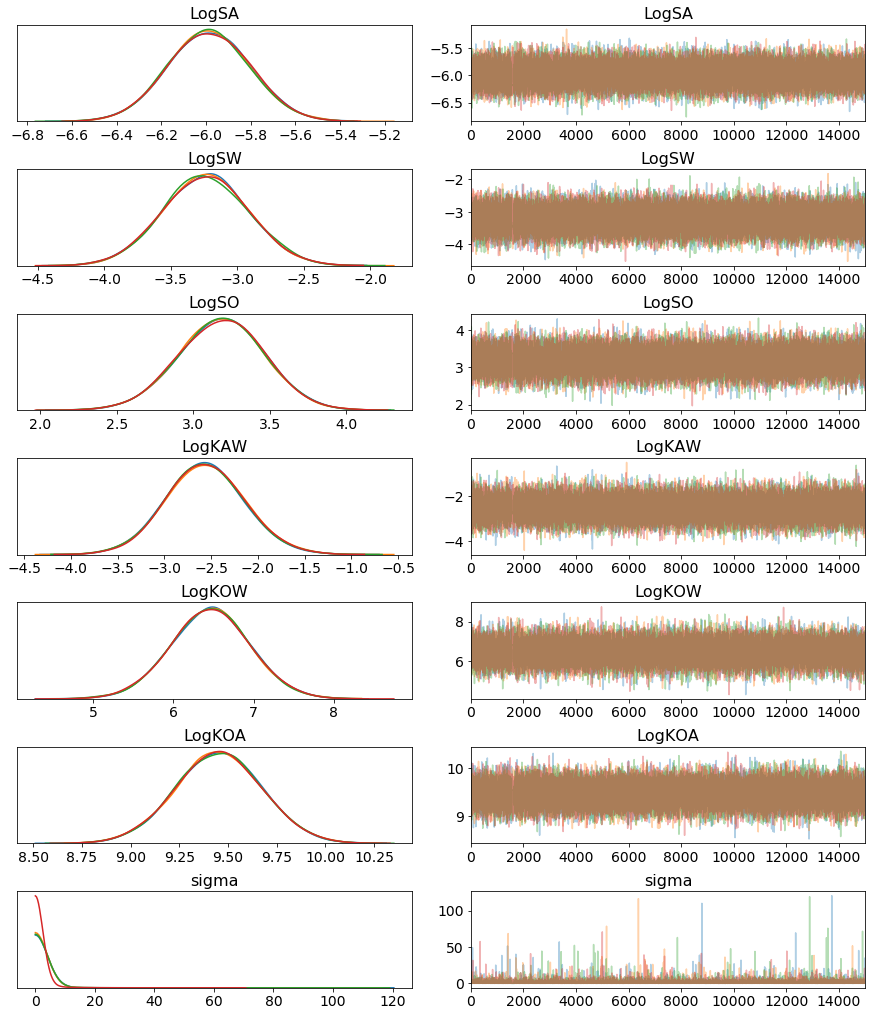

In [6]:
#with sixparam_model:
    # instantiate sampler - without this we just use NUTS
    #step = pm.Slice()
    # draw 5000 posterior samples
    #sixparam_trace = pm.sample(15000, tune=50000)#, step=step)
pm.traceplot(sixparam_trace);

In [7]:
pm.summary(sixparam_trace)
#For p,p'-DDE, nothing much was changed! This indicates that the measurements were fairly good 

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
LogSA,-5.986158,0.180105,0.000839,-6.338701,-5.634639,58215.791296,1.000078
LogSW,-3.235886,0.317528,0.001366,-3.856245,-2.613132,53101.252489,0.999972
LogSO,3.184170,0.275998,0.001258,2.638673,3.716966,57081.630275,0.999997
LogKAW,-2.562293,0.414867,0.001957,-3.377779,-1.735673,58294.257336,1.000119
LogKOW,6.463075,0.488690,0.002577,5.494742,7.415219,53475.129642,0.999984
LogKOA,9.453560,0.217784,0.000833,9.019505,9.875687,60573.591468,0.999978
sigma,1.305791,2.452768,0.011773,0.007801,3.909381,42877.923817,0.999993


In [ ]:
#Yan says that the GC-RT value for TCiPP is wrong in Brommer & Okeme - let's see if we can flag it with this method.
#So here we can try a simple case of just 3 parameters Kow, Kaw, Koa and see what we get. To get this solution, we will use 
#the data as the coefficients in a regression of 0 = LogKOW*(-1) + LogKAW*(1)+LogKOA*(1) where our "observations" in
#this case are:
x = [1,-1,-1,1] #Order is: Sa, Sw, Kow, Koa
y = 0
#Then, we set up our Bayesian model with the measurements as priors for the model regression parameters. This use of a strong 
#prior reflects our knowledge of the measured values of the compounds, while the model tells us whether this works.
#For this example we are using p,p'-DDE as our test compound. 
import pymc3 as pm
import arviz as az
comp = "TCiPP"
#Here we can test what impact changing the vapour pressure has on the overall result - does it converge better?
uLDV.loc[comp,'LogPL'] = ufloat(-3.12,0.89)
uLDV.loc[comp,'LogKOA'] = ufloat(9.68,0.96)
uLDV.loc[:,'LogSA'] = unumpy.log10(10**(uLDV.LogPL)/(R*T))
basic_model = pm.Model()
beta = [0,0,0,0]
with basic_model:
    #Define priors
    sigma = pm.HalfCauchy('sigma', beta=10, testval=0.) #Model error
    #alpha = pm.Normal('alpha', 0, sigma=1e-3) #Acceptable misclosure error
    #For the phys-chem properties, we have some choices of priors depending on our confidence in the data.
    #For our defaults we can use normal distributions, since we have measured values and have adjusted them to account
    #for our level of confidence. Of course, th
    beta[0] = pm.Normal('LogSA', mu = uLDV.loc[comp,'LogSA'].n, sigma=uLDV.loc[comp,'LogSA'].s) #.n = nominal value and .s = std dev.
    beta[1] = pm.Normal('LogSW', mu = uLDV.loc[comp,'LogSW'].n, sigma=uLDV.loc[comp,'LogSW'].s)
    beta[2] = pm.Normal('LogKOW', mu = uLDV.loc[comp,'LogKOW'].n, sigma=uLDV.loc[comp,'LogKOW'].s)
    beta[3] = pm.Normal('LogKOA', mu = uLDV.loc[comp,'LogKOA'].n, sigma=uLDV.loc[comp,'LogKOA'].s)
    #Students T distribution has fatter tails, so implies less confidence in the values. We can use this as a way of saying
    #that we think there might be some bias in the measured values.
    #beta[0] = pm.StudentT('LogKOW', nu = 1,mu = uLDV.loc[comp,'LogKOW'].n, sd=uLDV.loc[comp,'LogKOW'].s) #.n = nominal value and .s = std dev.
    #beta[1] = pm.StudentT('LogKAW', nu = 1,mu = uLDV.loc[comp,'LogKAW'].n, sd=uLDV.loc[comp,'LogKAW'].s)
    #beta[2] = pm.StudentT('LogKOA', nu = 1,mu = uLDV.loc[comp,'LogKOA'].n, sd=uLDV.loc[comp,'LogKOA'].s)
    #beta[3] = 
    
    mu = beta[0]*x[0] + beta[1]*x[1] + beta[2]*x[2]+ beta[3]*x[3]
    
    # Likelihood (sampling distribution) of observations
    #Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=y)#Normal
    Y_obs = pm.StudentT('Y_obs',nu = 3, mu=mu, sigma=sigma, observed=y)#For robust regression (broader tails)
    


D:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [LogKOA, LogKOW, LogSW, LogSA, sigma]
Sampling 4 chains: 100%|██████████████████████████████████████████████████| 260000/260000 [02:34<00:00, 1688.30draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


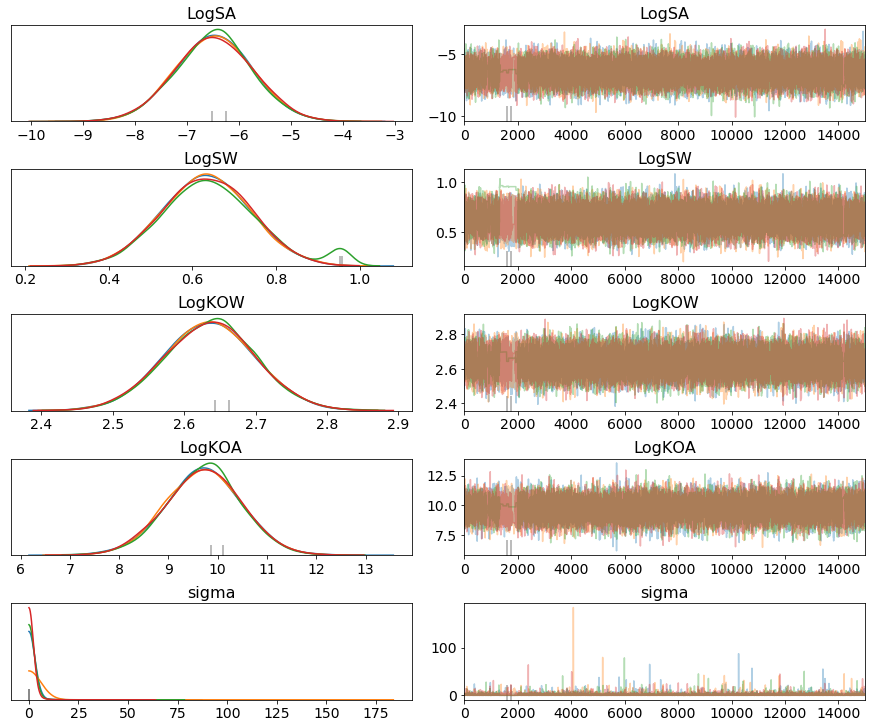

In [40]:
with basic_model:
    # instantiate sampler - without this we just use NUTS
    #step = pm.Slice()
    # draw 5000 posterior samples
    trace = pm.sample(15000, tune=50000)#, step=step)
pm.traceplot(trace);

In [38]:
pm.summary(trace) #Using default's value Sa = -5.61. Very low adjustment of parameters - outputs match inputs.
#downwards adjustment of the vapour pressure and a corresponding increase in the Koa

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
LogSA,-5.632057,0.763005,0.012455,-7.128847,-4.164824,5332.890896,1.000150
LogSW,0.634242,0.103637,0.000959,0.434521,0.842402,13858.426205,1.000108
LogKOW,2.635064,0.063298,0.000811,2.507706,2.754635,8466.094666,1.000041
LogKOA,8.892398,0.857622,0.012797,7.203710,10.579010,7073.293493,1.000223
sigma,1.101961,2.134813,0.021073,0.012753,3.446463,18929.422534,1.000114


In [41]:
pm.summary(trace) #Using Yan's value Sa = -6.38 and Koa = 9.68. So, pretty big adjustment for some of these properties - including a 
#downwards adjustment of the vapour pressure and a corresponding increase in the Koa

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
LogSA,-6.479964,0.730643,0.005291,-7.903539,-5.043809,22553.363312,0.999981
LogSW,0.637748,0.109813,0.002925,0.421183,0.852772,780.464477,1.002854
LogKOW,2.635913,0.063610,0.000540,2.511703,2.761653,20405.967405,1.000112
LogKOA,9.717518,0.756979,0.005638,8.219280,11.197674,24880.773496,1.000004
sigma,1.098734,2.180886,0.017314,0.015256,3.385264,22190.090633,1.000156


In [33]:
pm.summary(trace) #Sa = -5.31 without Wa1 paper value - adjusted to -5.37 & Koa adjusted to 8.73
#uLDV.loc['TCiPP','LogSA']


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
LogSA,-5.376988,0.714258,0.005740,-6.742673,-3.942730,18361.815359,1.000252
LogSW,0.634929,0.104685,0.000911,0.433797,0.843281,16567.502075,1.000184
LogKOW,2.635525,0.063172,0.000397,2.512154,2.758563,26393.429514,0.999995
LogKOA,8.734185,0.853034,0.005643,7.070758,10.453601,22177.285269,1.000064
sigma,1.132044,2.390734,0.014739,0.025714,3.457592,33584.884987,0.999997


Sadly, we don't have all six parameters for all of the compounds. But, we can use the same approach and the same system of equations, just solving for whatever we don't have. So, as a next step lets look at what properties we have for each of the compounds

In [11]:
#Define a vector with the properties that are absent. This order is fixed as: Sa, Sw, So, Kaw, Kow, Koa
propsabsent = unumpy.isnan([uLDV.loc[:,'LogSA'],uLDV.loc[:,'LogSW']\
            ,uLDV.loc[:,'LogSO'],uLDV.loc[:,'LogKAW'],\
            uLDV.loc[:,'LogKOW'],uLDV.loc[:,'LogKOA']]).T
uLDV.loc[:,'LogSA_absent'] = propsabsent[:,0]
uLDV.loc[:,'LogSW_absent'] = propsabsent[:,1]
uLDV.loc[:,'LogSO_absent'] = propsabsent[:,2]
uLDV.loc[:,'LogKAW_absent'] = propsabsent[:,3]
uLDV.loc[:,'LogKOW_absent'] = propsabsent[:,4]
uLDV.loc[:,'LogKOA_absent'] = propsabsent[:,5]
uLDV.loc[:,'n_absent'] = uLDV.loc[:,'LogSA_absent':'LogKOA_absent'].sum(axis=1)
uLDV.loc[:,'LogSA_absent':'n_absent']

,LogSA_absent,LogSW_absent,LogSO_absent,LogKAW_absent,LogKOW_absent,LogKOA_absent,n_absent
Compound Name,,,,,,,
cyclopentadecanone,False,False,True,True,False,False,2
15-pentadecanolide,False,False,True,True,False,True,3
Musk Ambrette,False,True,True,True,True,False,4
16-hexadecanolide,False,False,True,True,False,False,2
Celestolide,False,False,True,True,False,False,2
Muskonate,False,False,True,True,False,False,2
Phantolide,False,False,True,True,False,False,2
Cervolide,False,False,True,True,False,False,2
Traseolide,False,False,True,True,False,False,2


In [13]:
#Using this data, we can group compounds by the properties missing, since for each combination of properties
#missing there will be a different system of equations. You could achieve the same result with row reduction,
#but this way is nice and explicit. So, for instance, let's start with the simples case: compounds with no
#properties missing. We already know the only compound here will be p,p'DDE
number_absent = 0
uLDV.loc[uLDV.n_absent==number_absent,'LogSA_absent':'n_absent']

,LogSA_absent,LogSW_absent,LogSO_absent,LogKAW_absent,LogKOW_absent,LogKOA_absent,n_absent
Compound Name,,,,,,,
"p,p'- DDE",False,False,False,False,False,False,0


In [14]:
#Now, let's look at all the compounds with a single property missing:
number_absent = 1
uLDV.loc[uLDV.n_absent==number_absent,'LogSA_absent':'n_absent']

,LogSA_absent,LogSW_absent,LogSO_absent,LogKAW_absent,LogKOW_absent,LogKOA_absent,n_absent
Compound Name,,,,,,,
Tonalide,False,False,True,False,False,False,1
Galaxolide 1,False,False,True,False,False,False,1
"p,p'-DDD",False,False,True,False,False,False,1
aldrin,False,False,True,False,False,False,1
EHDPP,False,False,True,False,False,False,1


In [19]:
#Conveniently enough, all of these compounds are missing the same property - octanol solubility. We can
#therefore just go ahead and eliminate LogSO from the system of equations:
basemat = np.array([[1,-1,0,-1,0,0],[1,0,-1,0,0,1],[0,1,-1,0,1,0]]) #Order is: Sa, Sw, So, Kaw, Kow, Koa
#We can see that we need to do: row 2 - row 3
X = np.array([basemat[0],basemat[1] - basemat[2]])
X

array([[ 1, -1,  0, -1,  0,  0],
       [ 1, -1,  0,  0, -1,  1]])

In [ ]:
#TONALIDE
#Now, we just set up the above Bayesian regression for each of  these compounds. Here we will start with Tonalide
#Our changes are to the system of equations as above, and we will eliminate So
X = np.array([basemat[0],basemat[1] - basemat[2]])
y = 0
comp = "Tonalide"
props_model = pm.Model()
beta = [0,0,0,0,0,0]
with props_model:
    #Define priors
    sigma = pm.HalfCauchy('sigma', beta=1., testval=1.) #Model error
    #alpha = pm.Normal('alpha', 0, sigma=1e-3) #Acceptable misclosure error
    #For the phys-chem properties, we have some choices of priors depending on our confidence in the data.
    #For our defaults we can use normal distributions, since we have measured values and have adjusted them to account
    #for our level of confidence. Of course, th
    beta[0] = pm.Normal('LogSA', mu = uLDV.loc[comp,'LogSA'].n, sigma=uLDV.loc[comp,'LogSA'].s) #.n = nominal value and .s = std dev.
    beta[1] = pm.Normal('LogSW', mu = uLDV.loc[comp,'LogSW'].n, sigma=uLDV.loc[comp,'LogSW'].s)
    #Set So = 0
    beta[2] = 0#pm.Normal('LogSO', mu = uLDV.loc[comp,'LogSO'].n, sigma=uLDV.loc[comp,'LogSO'].s)
    beta[3] = pm.Normal('LogKAW', mu = uLDV.loc[comp,'LogKAW'].n, sigma=uLDV.loc[comp,'LogKAW'].s) #.n = nominal value and .s = std dev.
    #Kow can be converted to 
    #beta[4] = pm.Normal('LogKOWd', mu = uLDV.loc[comp,'LogKOWd'].n, sigma=uLDV.loc[comp,'LogKOWd'].s) 
    beta[4] = pm.Normal('LogKOW', mu = uLDV.loc[comp,'LogKOW'].n, sigma=uLDV.loc[comp,'LogKOW'].s)
    beta[5] = pm.Normal('LogKOA', mu = uLDV.loc[comp,'LogKOA'].n, sigma=uLDV.loc[comp,'LogKOA'].s)
    #Students T distribution has fatter tails, so implies less confidence in the values. We can use this as a way of saying
    #that we think there might be some bias in the measured values.
    #beta[3] = pm.StudentT('LogKOW', nu = 1,mu = uLDV.loc[comp,'LogKOW'].n, sd=uLDV.loc[comp,'LogKOW'].s) #.n = nominal value and .s = std dev.
    #beta[4] = pm.StudentT('LogKAW', nu = 1,mu = uLDV.loc[comp,'LogKAW'].n, sd=uLDV.loc[comp,'LogKAW'].s)
    #beta[5] = pm.StudentT('LogKOA', nu = 1,mu = uLDV.loc[comp,'LogKOA'].n, sd=uLDV.loc[comp,'LogKOA'].s)
    #beta[3] = 
    
    epsilon = np.dot(X,beta) #This gives us the misclosure error for each of the three equations
    #The model tries to fit to an observation, in this case that the misclosure should be 0.
    mu = np.sum(epsilon**2)#Here we are going to use the sum of squares, equivalent to the Schenker method, but Bayesian
    # Likelihood (sampling distribution) of observations
    #Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=y)#Normal
    Y_obs = pm.StudentT('Y_obs',nu = 3, mu=mu, sigma=sigma, observed=y)#Students for robust regression (broader tails)
    props_trace = pm.sample(15000, tune=50000)#, step=step)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [LogKOA, LogKOW, LogKAW, LogSW, LogSA, sigma]
Sampling 4 chains:  94%|██████████████████████████████████████████████▊   | 243612/260000 [01:37<00:15, 1028.70draws/s]

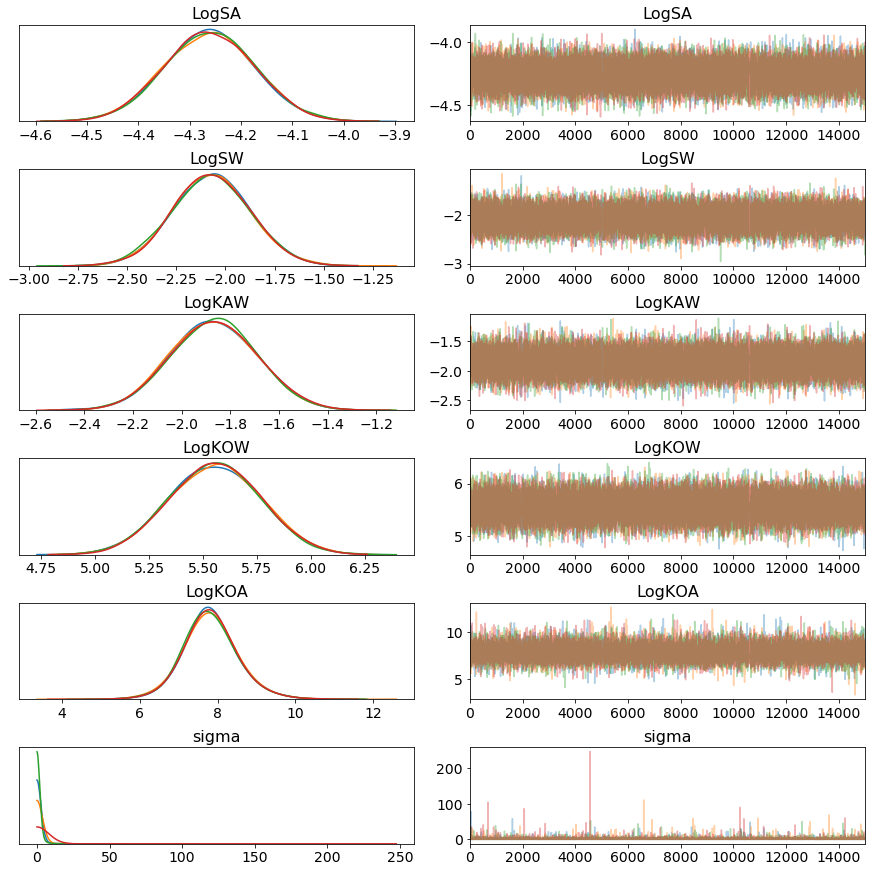

In [21]:
#TONALIDE
pm.traceplot(props_trace);

In [25]:
#TONALIDE
pm.summary(props_trace)


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
LogSA,-4.260343,0.087156,0.000675,-4.432229,-4.090946,21087.577800,1.000009
LogSW,-2.070733,0.189566,0.001401,-2.439415,-1.693228,21194.231135,1.000345
LogKAW,-1.871993,0.178542,0.001671,-2.212669,-1.510975,12866.892673,1.000023
LogKOW,5.557114,0.209507,0.001610,5.150599,5.974096,18411.850700,1.000385
LogKOA,7.809862,0.675899,0.004913,6.514911,9.234066,22156.137261,1.000210
sigma,1.204737,4.539523,0.022502,0.003621,3.715392,36139.049050,0.999974


In [ ]:
#TONALIDE
pm.summary(props_trace)